# Simple Linear Regression on Crypto

In [206]:
import pandas as pd
import yfinance as yf
from ta import add_all_ta_features
from datetime import datetime, timedelta
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go

# 1. Get Price Data

In [253]:
def getCryptoPrice(ticker="BTC-USD", n_days=1000):

    # Time periods
    now = datetime.now()

    # How far back to retrieve
    ago = now - timedelta(days=n_days)

    # Designating the Ticker
    crypto = yf.Ticker(ticker)

    # Getting price history
    df = crypto.history(
        start=ago.strftime("%Y-%m-%d"), 
        end=now.strftime("%Y-%m-%d"), 
        interval="1d"
    )

    # Handling missing data from yahoo finance
    df = df.reindex(
        [df.index.min()+pd.offsets.Day(i) for i in range(df.shape[0])],
        fill_value=None
    ).fillna(method='ffill')

    # Dropping Columns
    df.drop(
        ['Dividends', 'Stock Splits'], 
        axis=1,
        inplace=True
    )

    return df

In [311]:
df = getCryptoPrice(ticker="BTC-USD", n_days=400)

df

,Open,High,Low,Close,Volume
Date,,,,,
2020-09-05,10512.530273,10581.571289,9946.675781,10169.567383,4.491657e+10
2020-09-06,10167.216797,10353.927734,10056.885742,10280.351562,3.707146e+10
2020-09-07,10280.998047,10399.153320,9916.493164,10369.563477,3.370310e+10
2020-09-08,10369.306641,10414.775391,9945.110352,10131.516602,3.343093e+10
2020-09-09,10134.151367,10350.542969,10017.250977,10242.347656,2.412829e+10
...,...,...,...,...,...
2021-10-02,48137.468750,48282.062500,47465.496094,47711.488281,3.061435e+10
2021-10-03,47680.027344,49130.691406,47157.289062,48199.953125,2.663812e+10
2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344,3.338317e+10


## Adding Technical Indicators

In [312]:
df = add_all_ta_features(
    df, 
    open="Open", 
    high="High", 
    low="Low", 
    close="Close", 
    volume="Volume", 
    fillna=True
)

df

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-05,10512.530273,10581.571289,9946.675781,10169.567383,4.491657e+10,-1.337901e+10,4.491657e+10,-0.297864,0.000000e+00,50.000000,...,-64.893183,0.000000,10169.567383,0.000000,0.000000,0.000000,0.000000,-71.759801,0.000000,0.000000
2020-09-06,10167.216797,10353.927734,10056.885742,10280.351562,3.707146e+10,5.327528e+09,8.198803e+10,0.064979,4.106931e+12,0.000000,...,-47.443985,0.000000,10194.383665,0.000000,-1.411558,-0.282312,-1.129246,1.089370,1.083479,1.089370
2020-09-07,10280.998047,10399.153320,9916.493164,10369.563477,3.370310e+10,3.489824e+10,1.156911e+11,0.301650,3.949758e+12,0.000000,...,-31.877129,0.000000,10234.465387,0.000000,-3.163656,-0.858580,-2.305076,0.867790,0.864047,1.966614
2020-09-08,10369.306641,10414.775391,9945.110352,10131.516602,3.343093e+10,2.800424e+10,8.226020e+10,0.187794,2.248631e+12,0.000000,...,-67.669447,0.000000,10207.824891,0.000000,-4.609510,-1.608766,-3.000744,-2.295631,-2.322391,-0.374163
2020-09-09,10134.151367,10350.542969,10017.250977,10242.347656,2.412829e+10,3.646718e+10,1.063885e+11,0.210488,2.309422e+12,18.793719,...,-51.005080,0.000000,10218.771938,0.000000,-7.626736,-2.812360,-4.814376,1.093924,1.087984,0.715667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02,48137.468750,48282.062500,47465.496094,47711.488281,3.061435e+10,2.595646e+12,1.081254e+12,0.078539,1.911563e+13,55.072241,...,-8.377541,-2040.858490,45546.292257,11.361474,-2.040357,-1.554728,-0.485628,-0.842641,-0.846211,369.159468
2021-10-03,47680.027344,49130.691406,47157.289062,48199.953125,2.663812e+10,2.597157e+12,1.107892e+12,0.087725,1.824365e+13,61.022585,...,-9.961791,-788.801620,45674.419879,18.445808,-3.671180,-1.978019,-1.693162,1.023789,1.018584,373.962670
2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344,3.338317e+10,2.621020e+12,1.141275e+12,0.072291,1.999129e+13,69.587151,...,-3.556407,500.911328,46191.975941,12.710171,-3.313671,-2.245149,-1.068522,1.894087,1.876373,382.939937


# 2. Data Transformation/Preprocessing
Changing from time-series data to tabular data.

__E.g.)__ A 10% increase in Volume _from 10 days ago to today_ leads to 10% increase in the Open price in the _next_ 10 days. 

In [313]:
def transformData(df):
    """
    Transforming data into X variables for training.  Uses percent change and 
    multiplies the percentage by 100 rounded to 2 decimal places.
    """
    # Transforming data
    new_df = df.pct_change(
        10
    ).apply(
        lambda x: round(x*100, 2)
    ).replace(
        [np.inf, -np.inf], 
        np.nan
    )
    
    # Dropping Nans
    new_df = new_df.dropna(
        thresh=round(new_df.shape[1]*.7) # If 70% of the values in the row are Nans, drop the whole row
    ).dropna(
        axis=1,
        thresh=round(new_df.shape[0]*.7) # If 70% of the values in the columns are Nans, drop the whole column
    )
    
    # What the percent change is going to be in the next days AKA the Y Variable
    new_df['future_10_days']= df['Open'].pct_change(
        10
    ).shift(
        -10
    ).apply(
        lambda x: round(x*100, 2)
    )

    # Dropping the last NaNs from the Y variable
    new_df = new_df.dropna(
        subset=['future_10_days']
    )

    # Filling in the rest of the NaNs with the most recent value
    new_df = new_df.fillna(method='ffill').dropna()

    return new_df

In [314]:
new_df = transformData(df)

new_df

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,future_10_days
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-12,6.32,7.18,8.13,7.55,-13.66,70.93,69.73,135.27,-439.16,20.41,...,171.03,2.13,-271.31,-23.50,-14.57,139.61,-100.00,-100.00,192.26,13.33
2020-10-13,6.73,7.68,7.23,7.75,16.82,79.35,100.78,128.15,-400.00,35.47,...,426.13,3.03,625.85,-31.41,-18.00,-778.65,-100.00,-100.00,206.78,14.83
2020-10-14,8.15,7.84,7.37,6.97,37.37,62.64,94.43,103.68,-2195.54,36.91,...,873.12,3.69,475.89,-45.58,-23.80,-473.01,-64.63,-64.50,144.71,13.15
2020-10-15,6.91,7.09,6.17,6.40,26.32,50.02,87.65,59.25,355.96,37.55,...,1189.44,4.29,55.67,-55.31,-30.30,-828.00,-48.52,-48.39,108.97,14.72
2020-10-16,6.51,6.82,6.23,6.59,15.14,55.23,97.01,75.97,-236.76,34.59,...,1369.72,4.48,-617.69,-63.39,-36.67,637.82,-10.71,-10.79,154.94,13.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-22,-10.02,-5.15,-9.30,-5.40,36.79,0.12,-7.32,97.44,-1.28,-25.11,...,49.34,-1.47,24.70,-46.27,-91.30,-147.38,271.30,262.16,-6.93,18.34
2021-09-23,-5.42,-3.55,-1.11,-0.15,-16.42,1.55,-0.89,16.08,-54.33,-25.53,...,72.05,-1.05,-91.48,-72.33,-88.76,-121.98,-226.89,-223.50,-0.20,9.46
2021-09-24,-0.15,-4.53,-8.53,-9.03,10.83,0.04,-7.88,3.91,146.16,-33.53,...,101.01,-1.43,54.43,-33.53,-81.29,-180.98,-196.67,-201.28,-11.52,7.38


# 3. Fit to Linear Model

In [315]:
# Train, test, split
X = new_df.drop('future_10_days', axis=1)

y = new_df[['future_10_days']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20
)

In [316]:
# Model object
reg = LinearRegression()

# Fitting
reg.fit(X_train, y_train)

# Getting predictions
preds = reg.predict(X_test)

## Evaluation

In [317]:
# RMSE
print("RMSE:",mean_squared_error(
    y_test, 
    preds, 
    squared=False
))

# Coefficients
print("Coefficients:\n", reg.coef_)

# Intercept
print("Intercept:", reg.intercept_)

RMSE: 101.90019017078254
Coefficients:
 [[ 6.18829718e-03  1.83360982e-03  1.58762932e-02  2.00305457e-02
  -4.70652950e-02  5.15583992e-03  2.81984745e-03  3.10534120e-03
  -4.78396341e-04 -3.08255085e-02  3.90456150e-04 -1.81712404e-03
   2.71564569e-03  7.45162278e-04  1.64068933e-02 -2.33422694e-04
   1.49573122e-02  1.95698670e-02  8.96805261e-03  3.80971891e-02
  -9.39806104e-04  1.47949970e-02  1.45267363e-02  1.49360614e-02
  -1.95138931e-02  1.89552402e-04  9.49039515e-03  1.56209241e-02
   1.30710533e-02  1.48487969e-02  1.82197537e-02 -1.41050727e-03
   8.77952404e-04  3.01724193e-03 -4.31921853e-04  1.59001544e-02
   1.27937769e-02  1.41879889e-02  1.24274717e-02 -4.90392832e-02
   2.25616581e-02 -2.83679906e-02  4.18489436e-03 -7.15605146e-03
  -1.78878989e-03 -2.94707268e-03 -1.00034217e-03  2.37010255e-03
  -8.54819951e-04 -1.94614050e-03 -4.81532953e-03 -1.53901033e-03
   1.51818475e-02  1.13213387e-02  1.31817713e-02  1.01677554e-02
   4.76057221e-03  2.33922565e-03 -7

In [320]:
# Making a comparison DF
compare = pd.DataFrame()

compare['actual'] = y_test['future_10_days'].reset_index(drop=True)

compare['preds'] = preds

# Check to see if the predictions at least point in the correct direction
compare['same_direction'] = (
    compare['actual'].apply(lambda x: x>0)==compare['preds'].apply(lambda x: x>0)
)

display(compare)

# How often did predictions land in the same direction as the actual values?
dir_df = compare['same_direction'].value_counts().to_frame()

dir_df

,actual,preds,same_direction
0,-22.42,-4.159017,True
1,4.45,-7.342899,False
2,12.55,4.643813,True
3,-6.27,273.701143,False
4,4.78,-10.076080,False
...,...,...,...
65,8.46,17.955019,True
66,16.07,1.003897,True
67,-9.61,-11.311116,True
68,41.62,2.972386,True


,same_direction
True,41
False,29


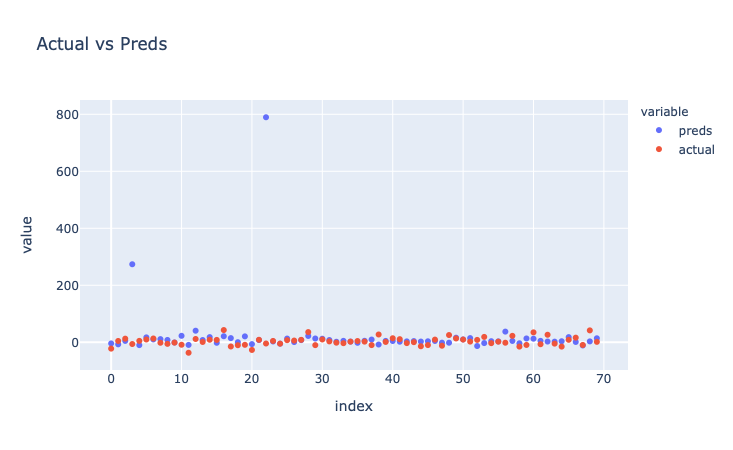

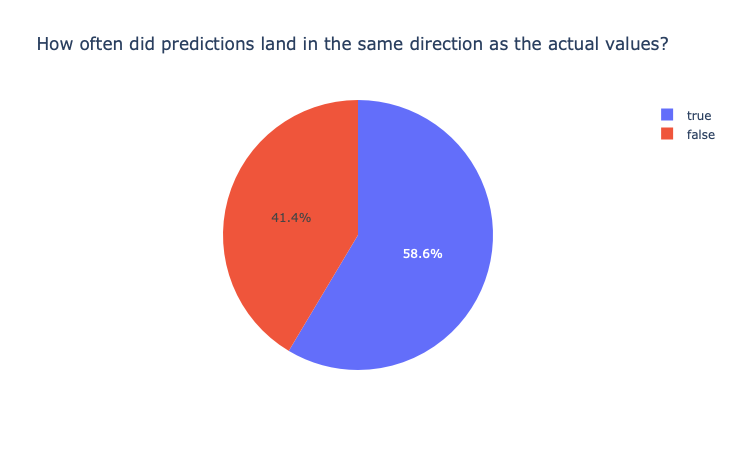

In [328]:
# Visualizing results
fig = px.scatter(
    compare,
    x=compare.index,
    y=['preds', 'actual'],
    title='Actual vs Preds'
)

fig.show()

fig = px.pie(
    dir_df,
    names=dir_df.index,
    values=dir_df['same_direction'],
    title='How often did predictions land in the same direction as the actual values?'
)

fig.show()

# 4. Backtesting Linear Regression